# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

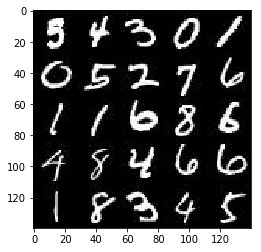

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

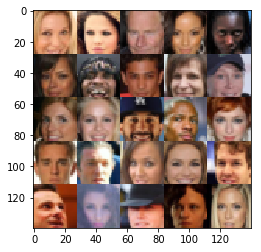

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0


/home/andres/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input_ph = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_ph = tf.placeholder(tf.float32, (None, z_dim))
    lr_ph = tf.placeholder(tf.float32)

    return real_input_ph, z_ph, lr_ph


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/andres/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/andres/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/andres/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/andres/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/andres/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/andres/anaconda3/lib/python3.6/site-packages/zmq/eventloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # I'll use DCGANs for this project, I hope this doesn't comlicate things much
    
    # alpha for the leaky relu activation function
    alpha = 0.2
    keep_proba = 0.8
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # first conv layer with 15 filters and a convolution size of 3
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # drop out renormalization
        x1 = tf.contrib.layers.dropout(x1, keep_prob=keep_proba)
        # leaky relu
        x1 = tf.maximum(alpha * x1, x1)
        
        # second conv layer with 30 filters and a convulution size of 3
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.contrib.layers.dropout(x2, keep_prob=keep_proba)
        # We set training = True since we are not planning to further use 
        # the network for inference
        x2 =  tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.contrib.layers.dropout(x3, keep_prob=keep_proba)
        # We set training = True since we are not planning to further use 
        # the network for inference
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3 = tf.maximum(alpha * x3, x3)
        print(x3.shape[1:])
        # flatten convolutions to connect to dense layer
        flatten = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        output = tf.sigmoid(logits) 
        
    # why do we need two outputs?
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

(4, 4, 256)
(4, 4, 256)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # alpha for leaky relu
    alpha = 0.2
    # variable scope, when we train we don't reuse scope
    with tf.variable_scope("generator", reuse = not is_train):
        # create convolution stack which will have dims 7 x 7 x 50, 
        x1 = tf.layers.dense(z, 7* 7* 512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.contrib.layers.dropout(x1, keep_prob=0.8)
        # renormalize by batch
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # second convolution transpose, shape should be 14 x 14 x 25
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding="same", 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.contrib.layers.dropout(x2, keep_prob=0.8)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding="same", 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.contrib.layers.dropout(x3, keep_prob=0.8)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=1, padding="same", 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.contrib.layers.dropout(x4, keep_prob=0.8)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # final convolution transpose, shape should be 28 x 28 x out_channel_dim, I use a stride of 1 to preserve size
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, 
                                            strides=1, padding="same")
        
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    
    generator_model = generator(input_z, out_channel_dim=out_channel_dim, is_train=True)
    # Why one is True and the other one False
    discriminator_model_real, d_logits_real = discriminator(input_real, reuse=False)
    discriminator_model_fake, d_logits_fake = discriminator(generator_model, reuse=True)
    
    # why discriminator has 2 different losses???
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_logits_real) * (1-smooth)))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_logits_fake)))
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    # why does the generator_loss depends on d_logits_fake
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_logits_fake))
    )
    
    return discriminator_loss, generator_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(4, 4, 256)
(4, 4, 256)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_variables = tf.trainable_variables()
    discriminator_variables = [var for var in all_variables if var.name.startswith("discriminator")]
    generator_variables = [var for var in all_variables if var.name.startswith("generator")]
    
    # what is this with statement doing?
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train\
        .AdamOptimizer(learning_rate=learning_rate, beta1=beta1)\
        .minimize(d_loss, var_list=discriminator_variables)
        
        g_train_opt = tf.train\
        .AdamOptimizer(learning_rate=learning_rate, beta1=beta1)\
        .minimize(g_loss, var_list=generator_variables)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(4, 4, 256)
(4, 4, 256)
Epoch 1/2... Batch 10... Discriminator Loss: 0.6594... Generator Loss: 9.0362
Epoch 1/2... Batch 20... Discriminator Loss: 2.0428... Generator Loss: 24.2919
Epoch 1/2... Batch 30... Discriminator Loss: 0.5597... Generator Loss: 18.8285
Epoch 1/2... Batch 40... Discriminator Loss: 0.5604... Generator Loss: 8.9744
Epoch 1/2... Batch 50... Discriminator Loss: 1.8871... Generator Loss: 7.0991
Epoch 1/2... Batch 60... Discriminator Loss: 5.1949... Generator Loss: 5.9538
Epoch 1/2... Batch 70... Discriminator Loss: 0.8324... Generator Loss: 5.5285
Epoch 1/2... Batch 80... Discriminator Loss: 1.5623... Generator Loss: 2.9585
Epoch 1/2... Batch 90... Discriminator Loss: 0.7408... Generator Loss: 4.3127
Epoch 1/2... Batch 100... Discriminator Loss: 0.5588... Generator Loss: 6.2672


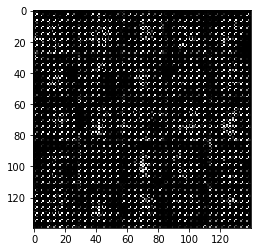

Epoch 1/2... Batch 110... Discriminator Loss: 0.5117... Generator Loss: 6.9182
Epoch 1/2... Batch 120... Discriminator Loss: 0.4724... Generator Loss: 7.2084
Epoch 1/2... Batch 130... Discriminator Loss: 0.5642... Generator Loss: 7.9972
Epoch 1/2... Batch 140... Discriminator Loss: 1.5329... Generator Loss: 1.3677
Epoch 1/2... Batch 150... Discriminator Loss: 2.0024... Generator Loss: 1.7708
Epoch 1/2... Batch 160... Discriminator Loss: 1.3630... Generator Loss: 1.8420
Epoch 1/2... Batch 170... Discriminator Loss: 1.3002... Generator Loss: 2.9233
Epoch 1/2... Batch 180... Discriminator Loss: 1.5422... Generator Loss: 4.9422
Epoch 1/2... Batch 190... Discriminator Loss: 1.8155... Generator Loss: 1.9831
Epoch 1/2... Batch 200... Discriminator Loss: 2.9352... Generator Loss: 2.6526


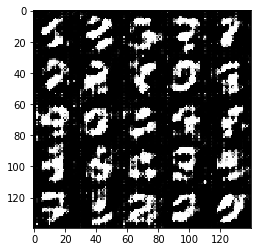

Epoch 1/2... Batch 210... Discriminator Loss: 1.2082... Generator Loss: 3.0479
Epoch 1/2... Batch 220... Discriminator Loss: 1.2658... Generator Loss: 1.8957
Epoch 1/2... Batch 230... Discriminator Loss: 1.6279... Generator Loss: 1.4334
Epoch 1/2... Batch 240... Discriminator Loss: 1.6309... Generator Loss: 1.0653
Epoch 1/2... Batch 250... Discriminator Loss: 1.4723... Generator Loss: 2.3925
Epoch 1/2... Batch 260... Discriminator Loss: 1.9529... Generator Loss: 1.1749
Epoch 1/2... Batch 270... Discriminator Loss: 1.0494... Generator Loss: 2.1091
Epoch 1/2... Batch 280... Discriminator Loss: 1.2058... Generator Loss: 1.6087
Epoch 1/2... Batch 290... Discriminator Loss: 1.3194... Generator Loss: 1.7087
Epoch 1/2... Batch 300... Discriminator Loss: 1.2975... Generator Loss: 1.0966


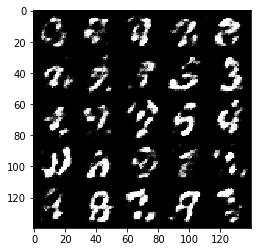

Epoch 1/2... Batch 310... Discriminator Loss: 1.1152... Generator Loss: 1.6936
Epoch 1/2... Batch 320... Discriminator Loss: 1.9965... Generator Loss: 0.6728
Epoch 1/2... Batch 330... Discriminator Loss: 1.4493... Generator Loss: 1.5104
Epoch 1/2... Batch 340... Discriminator Loss: 1.5500... Generator Loss: 3.3456
Epoch 1/2... Batch 350... Discriminator Loss: 1.3031... Generator Loss: 1.8426
Epoch 1/2... Batch 360... Discriminator Loss: 1.4183... Generator Loss: 3.1576
Epoch 1/2... Batch 370... Discriminator Loss: 1.0031... Generator Loss: 2.0766
Epoch 1/2... Batch 380... Discriminator Loss: 1.1933... Generator Loss: 1.5247
Epoch 1/2... Batch 390... Discriminator Loss: 1.2113... Generator Loss: 1.2873
Epoch 1/2... Batch 400... Discriminator Loss: 1.1017... Generator Loss: 1.8008


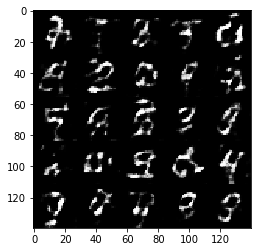

Epoch 1/2... Batch 410... Discriminator Loss: 1.2098... Generator Loss: 1.3168
Epoch 1/2... Batch 420... Discriminator Loss: 0.9684... Generator Loss: 2.0183
Epoch 1/2... Batch 430... Discriminator Loss: 1.0920... Generator Loss: 2.2120
Epoch 1/2... Batch 440... Discriminator Loss: 1.0246... Generator Loss: 1.4000
Epoch 1/2... Batch 450... Discriminator Loss: 0.9511... Generator Loss: 2.0393
Epoch 1/2... Batch 460... Discriminator Loss: 0.7981... Generator Loss: 2.2920
Epoch 2/2... Batch 10... Discriminator Loss: 0.8658... Generator Loss: 1.8943
Epoch 2/2... Batch 20... Discriminator Loss: 0.9909... Generator Loss: 1.5978
Epoch 2/2... Batch 30... Discriminator Loss: 1.2087... Generator Loss: 3.7166
Epoch 2/2... Batch 40... Discriminator Loss: 0.9332... Generator Loss: 2.3929
Epoch 2/2... Batch 50... Discriminator Loss: 1.0139... Generator Loss: 1.6251
Epoch 2/2... Batch 60... Discriminator Loss: 0.9064... Generator Loss: 3.1185
Epoch 2/2... Batch 70... Discriminator Loss: 0.9569... Gen

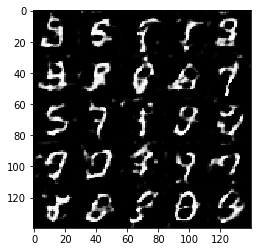

Epoch 2/2... Batch 110... Discriminator Loss: 0.9840... Generator Loss: 1.9644
Epoch 2/2... Batch 120... Discriminator Loss: 0.6814... Generator Loss: 2.8008
Epoch 2/2... Batch 130... Discriminator Loss: 0.9856... Generator Loss: 1.4317
Epoch 2/2... Batch 140... Discriminator Loss: 1.1003... Generator Loss: 3.0027
Epoch 2/2... Batch 150... Discriminator Loss: 0.9495... Generator Loss: 2.0358
Epoch 2/2... Batch 160... Discriminator Loss: 0.9408... Generator Loss: 2.3109
Epoch 2/2... Batch 170... Discriminator Loss: 1.1832... Generator Loss: 1.2472
Epoch 2/2... Batch 180... Discriminator Loss: 1.2871... Generator Loss: 2.7205
Epoch 2/2... Batch 190... Discriminator Loss: 1.0569... Generator Loss: 1.5748
Epoch 2/2... Batch 200... Discriminator Loss: 1.0935... Generator Loss: 1.5725


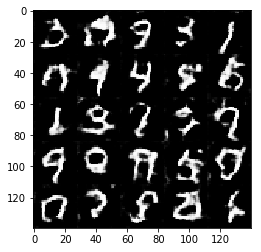

Epoch 2/2... Batch 210... Discriminator Loss: 1.8701... Generator Loss: 0.5781
Epoch 2/2... Batch 220... Discriminator Loss: 1.1484... Generator Loss: 1.8762
Epoch 2/2... Batch 230... Discriminator Loss: 1.1727... Generator Loss: 1.5417
Epoch 2/2... Batch 240... Discriminator Loss: 0.9023... Generator Loss: 1.8536
Epoch 2/2... Batch 250... Discriminator Loss: 1.0690... Generator Loss: 1.7081
Epoch 2/2... Batch 260... Discriminator Loss: 1.2563... Generator Loss: 1.0935
Epoch 2/2... Batch 270... Discriminator Loss: 1.2830... Generator Loss: 2.7058
Epoch 2/2... Batch 280... Discriminator Loss: 1.0373... Generator Loss: 1.4506
Epoch 2/2... Batch 290... Discriminator Loss: 1.0632... Generator Loss: 1.8070
Epoch 2/2... Batch 300... Discriminator Loss: 0.9508... Generator Loss: 1.9204


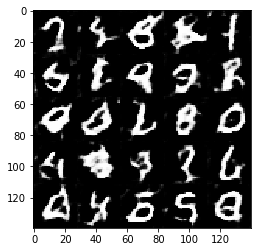

Epoch 2/2... Batch 310... Discriminator Loss: 1.1406... Generator Loss: 2.1955
Epoch 2/2... Batch 320... Discriminator Loss: 1.1847... Generator Loss: 1.8926
Epoch 2/2... Batch 330... Discriminator Loss: 1.2112... Generator Loss: 1.0493
Epoch 2/2... Batch 340... Discriminator Loss: 1.3016... Generator Loss: 1.4460
Epoch 2/2... Batch 350... Discriminator Loss: 1.0629... Generator Loss: 1.2360
Epoch 2/2... Batch 360... Discriminator Loss: 0.9276... Generator Loss: 2.0341
Epoch 2/2... Batch 370... Discriminator Loss: 1.1389... Generator Loss: 1.8211
Epoch 2/2... Batch 380... Discriminator Loss: 1.1786... Generator Loss: 1.1358
Epoch 2/2... Batch 390... Discriminator Loss: 0.9635... Generator Loss: 1.4730
Epoch 2/2... Batch 400... Discriminator Loss: 1.0298... Generator Loss: 1.5472


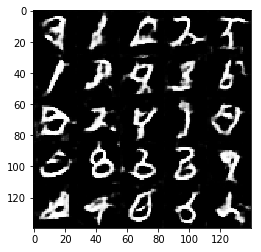

Epoch 2/2... Batch 410... Discriminator Loss: 1.0152... Generator Loss: 1.5401
Epoch 2/2... Batch 420... Discriminator Loss: 1.5438... Generator Loss: 3.0522
Epoch 2/2... Batch 430... Discriminator Loss: 1.0235... Generator Loss: 2.3897
Epoch 2/2... Batch 440... Discriminator Loss: 1.0763... Generator Loss: 1.3914
Epoch 2/2... Batch 450... Discriminator Loss: 1.1907... Generator Loss: 1.2588
Epoch 2/2... Batch 460... Discriminator Loss: 1.0066... Generator Loss: 1.1836


In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(4, 4, 256)
(4, 4, 256)
Epoch 1/1... Batch 10... Discriminator Loss: 0.9233... Generator Loss: 3.5529
Epoch 1/1... Batch 20... Discriminator Loss: 0.8941... Generator Loss: 4.4744
Epoch 1/1... Batch 30... Discriminator Loss: 0.6453... Generator Loss: 5.0004
Epoch 1/1... Batch 40... Discriminator Loss: 0.7197... Generator Loss: 6.3470
Epoch 1/1... Batch 50... Discriminator Loss: 0.6925... Generator Loss: 5.7806
Epoch 1/1... Batch 60... Discriminator Loss: 0.6381... Generator Loss: 6.8604
Epoch 1/1... Batch 70... Discriminator Loss: 0.5638... Generator Loss: 6.1414
Epoch 1/1... Batch 80... Discriminator Loss: 0.5364... Generator Loss: 6.4760
Epoch 1/1... Batch 90... Discriminator Loss: 0.6406... Generator Loss: 6.8713
Epoch 1/1... Batch 100... Discriminator Loss: 0.5267... Generator Loss: 7.7537


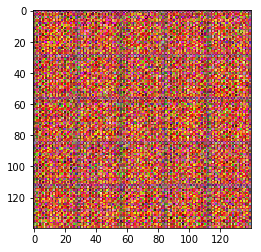

Epoch 1/1... Batch 110... Discriminator Loss: 0.5447... Generator Loss: 7.3281
Epoch 1/1... Batch 120... Discriminator Loss: 0.5207... Generator Loss: 8.0958
Epoch 1/1... Batch 130... Discriminator Loss: 0.5593... Generator Loss: 7.2056
Epoch 1/1... Batch 140... Discriminator Loss: 0.5644... Generator Loss: 5.8442
Epoch 1/1... Batch 150... Discriminator Loss: 0.5031... Generator Loss: 6.6168
Epoch 1/1... Batch 160... Discriminator Loss: 0.5497... Generator Loss: 7.8066
Epoch 1/1... Batch 170... Discriminator Loss: 0.5341... Generator Loss: 7.8238
Epoch 1/1... Batch 180... Discriminator Loss: 0.4651... Generator Loss: 8.1046
Epoch 1/1... Batch 190... Discriminator Loss: 0.5526... Generator Loss: 7.6756
Epoch 1/1... Batch 200... Discriminator Loss: 0.5073... Generator Loss: 7.8591


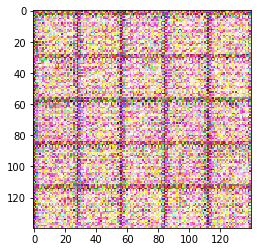

Epoch 1/1... Batch 210... Discriminator Loss: 0.5050... Generator Loss: 7.9168
Epoch 1/1... Batch 220... Discriminator Loss: 0.5489... Generator Loss: 7.9764
Epoch 1/1... Batch 230... Discriminator Loss: 0.5235... Generator Loss: 6.6380
Epoch 1/1... Batch 240... Discriminator Loss: 0.5424... Generator Loss: 7.4273
Epoch 1/1... Batch 250... Discriminator Loss: 0.4548... Generator Loss: 8.3950
Epoch 1/1... Batch 260... Discriminator Loss: 0.4944... Generator Loss: 8.5409
Epoch 1/1... Batch 270... Discriminator Loss: 0.5157... Generator Loss: 7.9527
Epoch 1/1... Batch 280... Discriminator Loss: 0.5348... Generator Loss: 6.5951
Epoch 1/1... Batch 290... Discriminator Loss: 0.4928... Generator Loss: 8.4045
Epoch 1/1... Batch 300... Discriminator Loss: 0.4532... Generator Loss: 8.0693


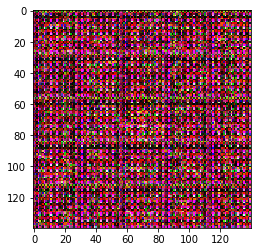

Epoch 1/1... Batch 310... Discriminator Loss: 0.4375... Generator Loss: 7.6553
Epoch 1/1... Batch 320... Discriminator Loss: 0.4535... Generator Loss: 6.2563
Epoch 1/1... Batch 330... Discriminator Loss: 0.4320... Generator Loss: 6.7408
Epoch 1/1... Batch 340... Discriminator Loss: 0.4405... Generator Loss: 6.8655
Epoch 1/1... Batch 350... Discriminator Loss: 0.4810... Generator Loss: 6.0631
Epoch 1/1... Batch 360... Discriminator Loss: 0.5223... Generator Loss: 6.0082
Epoch 1/1... Batch 370... Discriminator Loss: 0.4196... Generator Loss: 5.5695
Epoch 1/1... Batch 380... Discriminator Loss: 0.6264... Generator Loss: 4.4207
Epoch 1/1... Batch 390... Discriminator Loss: 0.4907... Generator Loss: 6.2499
Epoch 1/1... Batch 400... Discriminator Loss: 0.4501... Generator Loss: 6.9254


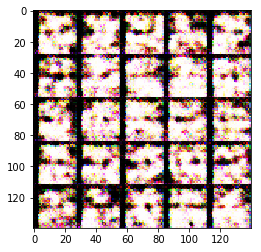

Epoch 1/1... Batch 410... Discriminator Loss: 0.4516... Generator Loss: 5.6233
Epoch 1/1... Batch 420... Discriminator Loss: 0.4727... Generator Loss: 5.4066
Epoch 1/1... Batch 430... Discriminator Loss: 0.4981... Generator Loss: 5.0399
Epoch 1/1... Batch 440... Discriminator Loss: 0.4463... Generator Loss: 6.3227
Epoch 1/1... Batch 450... Discriminator Loss: 0.4519... Generator Loss: 5.6741
Epoch 1/1... Batch 460... Discriminator Loss: 0.4144... Generator Loss: 6.0716
Epoch 1/1... Batch 470... Discriminator Loss: 0.4481... Generator Loss: 4.9508
Epoch 1/1... Batch 480... Discriminator Loss: 0.4086... Generator Loss: 6.2237
Epoch 1/1... Batch 490... Discriminator Loss: 0.4559... Generator Loss: 5.8348
Epoch 1/1... Batch 500... Discriminator Loss: 0.4281... Generator Loss: 5.7699


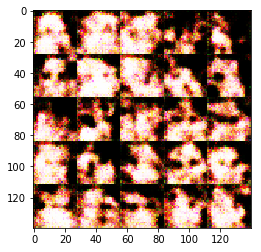

Epoch 1/1... Batch 510... Discriminator Loss: 0.4390... Generator Loss: 6.6529
Epoch 1/1... Batch 520... Discriminator Loss: 0.4181... Generator Loss: 5.7303
Epoch 1/1... Batch 530... Discriminator Loss: 0.4273... Generator Loss: 5.7449
Epoch 1/1... Batch 540... Discriminator Loss: 0.4086... Generator Loss: 5.7196
Epoch 1/1... Batch 550... Discriminator Loss: 0.4046... Generator Loss: 5.7400
Epoch 1/1... Batch 560... Discriminator Loss: 0.3908... Generator Loss: 6.1685
Epoch 1/1... Batch 570... Discriminator Loss: 0.4199... Generator Loss: 5.4350
Epoch 1/1... Batch 580... Discriminator Loss: 0.4169... Generator Loss: 5.5181
Epoch 1/1... Batch 590... Discriminator Loss: 0.4170... Generator Loss: 5.3554
Epoch 1/1... Batch 600... Discriminator Loss: 0.3955... Generator Loss: 5.6486


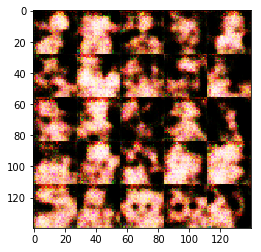

Epoch 1/1... Batch 610... Discriminator Loss: 0.3930... Generator Loss: 5.7246
Epoch 1/1... Batch 620... Discriminator Loss: 0.4017... Generator Loss: 5.3380
Epoch 1/1... Batch 630... Discriminator Loss: 0.4030... Generator Loss: 5.0181
Epoch 1/1... Batch 640... Discriminator Loss: 0.4223... Generator Loss: 4.4256
Epoch 1/1... Batch 650... Discriminator Loss: 0.4117... Generator Loss: 4.2766
Epoch 1/1... Batch 660... Discriminator Loss: 0.4106... Generator Loss: 4.8296
Epoch 1/1... Batch 670... Discriminator Loss: 0.4165... Generator Loss: 4.9487
Epoch 1/1... Batch 680... Discriminator Loss: 0.4347... Generator Loss: 4.0942
Epoch 1/1... Batch 690... Discriminator Loss: 0.4184... Generator Loss: 3.8894
Epoch 1/1... Batch 700... Discriminator Loss: 0.4134... Generator Loss: 5.1448


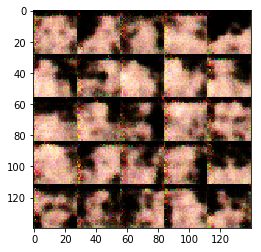

Epoch 1/1... Batch 710... Discriminator Loss: 0.4935... Generator Loss: 4.6765
Epoch 1/1... Batch 720... Discriminator Loss: 0.4301... Generator Loss: 3.8975
Epoch 1/1... Batch 730... Discriminator Loss: 0.4368... Generator Loss: 3.5139
Epoch 1/1... Batch 740... Discriminator Loss: 0.4832... Generator Loss: 3.5707
Epoch 1/1... Batch 750... Discriminator Loss: 0.4288... Generator Loss: 4.2112
Epoch 1/1... Batch 760... Discriminator Loss: 0.4100... Generator Loss: 4.1268
Epoch 1/1... Batch 770... Discriminator Loss: 0.4435... Generator Loss: 4.3384
Epoch 1/1... Batch 780... Discriminator Loss: 0.4495... Generator Loss: 4.3980
Epoch 1/1... Batch 790... Discriminator Loss: 0.4988... Generator Loss: 2.7186
Epoch 1/1... Batch 800... Discriminator Loss: 0.4733... Generator Loss: 3.3528


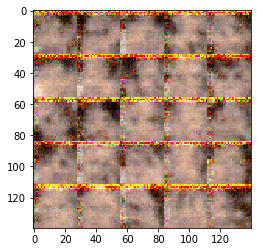

Epoch 1/1... Batch 810... Discriminator Loss: 0.4485... Generator Loss: 3.3100
Epoch 1/1... Batch 820... Discriminator Loss: 0.4629... Generator Loss: 4.0144
Epoch 1/1... Batch 830... Discriminator Loss: 0.4357... Generator Loss: 4.4302
Epoch 1/1... Batch 840... Discriminator Loss: 0.4058... Generator Loss: 5.0940
Epoch 1/1... Batch 850... Discriminator Loss: 0.3960... Generator Loss: 5.7793
Epoch 1/1... Batch 860... Discriminator Loss: 0.4313... Generator Loss: 5.2520
Epoch 1/1... Batch 870... Discriminator Loss: 0.3893... Generator Loss: 5.3930
Epoch 1/1... Batch 880... Discriminator Loss: 0.4056... Generator Loss: 5.2487
Epoch 1/1... Batch 890... Discriminator Loss: 0.3995... Generator Loss: 5.1851
Epoch 1/1... Batch 900... Discriminator Loss: 0.4033... Generator Loss: 4.9056


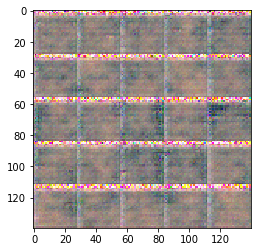

Epoch 1/1... Batch 910... Discriminator Loss: 0.3842... Generator Loss: 5.0875
Epoch 1/1... Batch 920... Discriminator Loss: 0.4135... Generator Loss: 3.8721
Epoch 1/1... Batch 930... Discriminator Loss: 0.4915... Generator Loss: 3.4323
Epoch 1/1... Batch 940... Discriminator Loss: 0.4721... Generator Loss: 3.2333
Epoch 1/1... Batch 950... Discriminator Loss: 0.4159... Generator Loss: 3.7553
Epoch 1/1... Batch 960... Discriminator Loss: 0.4068... Generator Loss: 4.7814
Epoch 1/1... Batch 970... Discriminator Loss: 0.4412... Generator Loss: 3.1937
Epoch 1/1... Batch 980... Discriminator Loss: 0.3939... Generator Loss: 4.3473
Epoch 1/1... Batch 990... Discriminator Loss: 0.4116... Generator Loss: 5.6343
Epoch 1/1... Batch 1000... Discriminator Loss: 0.3983... Generator Loss: 4.8720


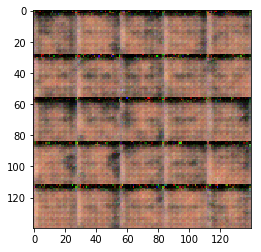

Epoch 1/1... Batch 1010... Discriminator Loss: 0.4180... Generator Loss: 5.5180
Epoch 1/1... Batch 1020... Discriminator Loss: 0.3939... Generator Loss: 4.9392
Epoch 1/1... Batch 1030... Discriminator Loss: 0.3827... Generator Loss: 4.9077
Epoch 1/1... Batch 1040... Discriminator Loss: 0.3971... Generator Loss: 5.1180
Epoch 1/1... Batch 1050... Discriminator Loss: 0.4021... Generator Loss: 4.8906
Epoch 1/1... Batch 1060... Discriminator Loss: 0.3850... Generator Loss: 5.2216
Epoch 1/1... Batch 1070... Discriminator Loss: 0.3983... Generator Loss: 6.0390
Epoch 1/1... Batch 1080... Discriminator Loss: 0.4518... Generator Loss: 4.0725
Epoch 1/1... Batch 1090... Discriminator Loss: 0.4427... Generator Loss: 4.0669
Epoch 1/1... Batch 1100... Discriminator Loss: 0.4913... Generator Loss: 3.6528


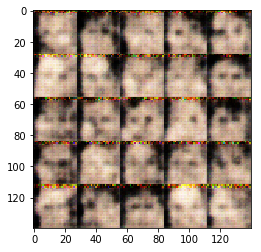

Epoch 1/1... Batch 1110... Discriminator Loss: 0.5054... Generator Loss: 3.2065
Epoch 1/1... Batch 1120... Discriminator Loss: 0.3953... Generator Loss: 4.3199
Epoch 1/1... Batch 1130... Discriminator Loss: 0.4311... Generator Loss: 4.6324
Epoch 1/1... Batch 1140... Discriminator Loss: 0.3933... Generator Loss: 5.0514
Epoch 1/1... Batch 1150... Discriminator Loss: 0.4473... Generator Loss: 4.9326
Epoch 1/1... Batch 1160... Discriminator Loss: 0.4080... Generator Loss: 4.7583
Epoch 1/1... Batch 1170... Discriminator Loss: 0.5316... Generator Loss: 2.5727
Epoch 1/1... Batch 1180... Discriminator Loss: 0.4801... Generator Loss: 3.5365
Epoch 1/1... Batch 1190... Discriminator Loss: 0.4778... Generator Loss: 3.9938
Epoch 1/1... Batch 1200... Discriminator Loss: 0.5149... Generator Loss: 3.4118


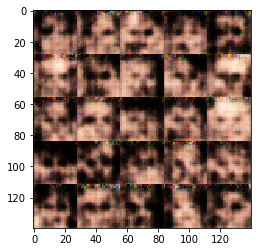

Epoch 1/1... Batch 1210... Discriminator Loss: 0.4326... Generator Loss: 3.6435
Epoch 1/1... Batch 1220... Discriminator Loss: 0.4347... Generator Loss: 4.0062
Epoch 1/1... Batch 1230... Discriminator Loss: 0.4630... Generator Loss: 3.4452
Epoch 1/1... Batch 1240... Discriminator Loss: 0.4708... Generator Loss: 3.3786
Epoch 1/1... Batch 1250... Discriminator Loss: 0.4411... Generator Loss: 3.8029
Epoch 1/1... Batch 1260... Discriminator Loss: 0.4667... Generator Loss: 3.4703
Epoch 1/1... Batch 1270... Discriminator Loss: 0.4823... Generator Loss: 2.8911
Epoch 1/1... Batch 1280... Discriminator Loss: 0.4400... Generator Loss: 4.2132
Epoch 1/1... Batch 1290... Discriminator Loss: 0.4597... Generator Loss: 3.9322
Epoch 1/1... Batch 1300... Discriminator Loss: 0.4470... Generator Loss: 3.8819


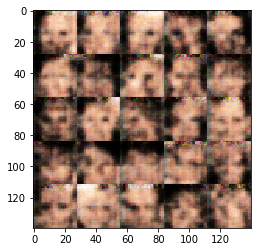

Epoch 1/1... Batch 1310... Discriminator Loss: 0.5330... Generator Loss: 3.6883
Epoch 1/1... Batch 1320... Discriminator Loss: 0.4794... Generator Loss: 3.3155
Epoch 1/1... Batch 1330... Discriminator Loss: 0.4556... Generator Loss: 4.2888
Epoch 1/1... Batch 1340... Discriminator Loss: 0.4596... Generator Loss: 3.6677
Epoch 1/1... Batch 1350... Discriminator Loss: 0.4936... Generator Loss: 2.6869
Epoch 1/1... Batch 1360... Discriminator Loss: 0.4646... Generator Loss: 3.8800
Epoch 1/1... Batch 1370... Discriminator Loss: 0.5411... Generator Loss: 2.9144
Epoch 1/1... Batch 1380... Discriminator Loss: 0.4967... Generator Loss: 3.5598
Epoch 1/1... Batch 1390... Discriminator Loss: 0.4447... Generator Loss: 3.8570
Epoch 1/1... Batch 1400... Discriminator Loss: 0.4566... Generator Loss: 3.9318


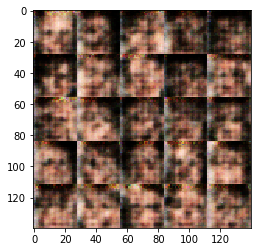

Epoch 1/1... Batch 1410... Discriminator Loss: 0.4919... Generator Loss: 3.3291
Epoch 1/1... Batch 1420... Discriminator Loss: 0.6164... Generator Loss: 2.9091
Epoch 1/1... Batch 1430... Discriminator Loss: 0.5078... Generator Loss: 3.6590
Epoch 1/1... Batch 1440... Discriminator Loss: 0.4960... Generator Loss: 3.6969
Epoch 1/1... Batch 1450... Discriminator Loss: 0.5493... Generator Loss: 2.7183
Epoch 1/1... Batch 1460... Discriminator Loss: 0.4571... Generator Loss: 3.8148
Epoch 1/1... Batch 1470... Discriminator Loss: 0.4783... Generator Loss: 3.2094
Epoch 1/1... Batch 1480... Discriminator Loss: 0.5144... Generator Loss: 3.2640
Epoch 1/1... Batch 1490... Discriminator Loss: 0.5398... Generator Loss: 2.7960
Epoch 1/1... Batch 1500... Discriminator Loss: 0.5760... Generator Loss: 3.0313


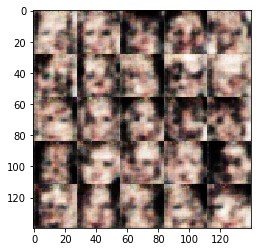

Epoch 1/1... Batch 1510... Discriminator Loss: 0.4686... Generator Loss: 3.6626
Epoch 1/1... Batch 1520... Discriminator Loss: 0.5255... Generator Loss: 2.8695
Epoch 1/1... Batch 1530... Discriminator Loss: 0.4698... Generator Loss: 3.1759
Epoch 1/1... Batch 1540... Discriminator Loss: 0.4839... Generator Loss: 3.8419
Epoch 1/1... Batch 1550... Discriminator Loss: 0.5171... Generator Loss: 3.8036
Epoch 1/1... Batch 1560... Discriminator Loss: 0.4634... Generator Loss: 3.9436
Epoch 1/1... Batch 1570... Discriminator Loss: 0.5446... Generator Loss: 3.5781
Epoch 1/1... Batch 1580... Discriminator Loss: 0.5714... Generator Loss: 3.4343
Epoch 1/1... Batch 1590... Discriminator Loss: 0.4423... Generator Loss: 4.1809
Epoch 1/1... Batch 1600... Discriminator Loss: 0.4893... Generator Loss: 3.1712


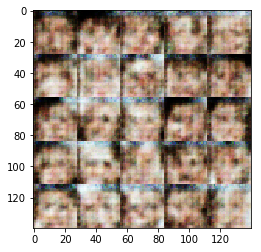

Epoch 1/1... Batch 1610... Discriminator Loss: 0.7186... Generator Loss: 2.3533
Epoch 1/1... Batch 1620... Discriminator Loss: 0.5489... Generator Loss: 3.5246
Epoch 1/1... Batch 1630... Discriminator Loss: 0.5437... Generator Loss: 3.0722
Epoch 1/1... Batch 1640... Discriminator Loss: 0.4734... Generator Loss: 3.4298
Epoch 1/1... Batch 1650... Discriminator Loss: 0.5517... Generator Loss: 3.2976
Epoch 1/1... Batch 1660... Discriminator Loss: 0.5668... Generator Loss: 3.1986
Epoch 1/1... Batch 1670... Discriminator Loss: 0.4848... Generator Loss: 3.1687
Epoch 1/1... Batch 1680... Discriminator Loss: 0.6277... Generator Loss: 3.0963
Epoch 1/1... Batch 1690... Discriminator Loss: 0.6437... Generator Loss: 2.3518
Epoch 1/1... Batch 1700... Discriminator Loss: 0.4998... Generator Loss: 3.6094


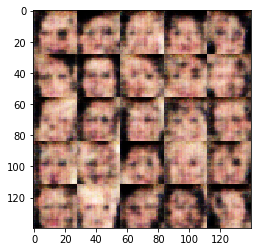

Epoch 1/1... Batch 1710... Discriminator Loss: 0.5574... Generator Loss: 2.7933
Epoch 1/1... Batch 1720... Discriminator Loss: 0.5133... Generator Loss: 3.1046
Epoch 1/1... Batch 1730... Discriminator Loss: 0.5398... Generator Loss: 2.8339
Epoch 1/1... Batch 1740... Discriminator Loss: 0.4889... Generator Loss: 3.2749
Epoch 1/1... Batch 1750... Discriminator Loss: 0.6219... Generator Loss: 2.6182
Epoch 1/1... Batch 1760... Discriminator Loss: 0.6716... Generator Loss: 3.4845
Epoch 1/1... Batch 1770... Discriminator Loss: 0.4604... Generator Loss: 4.5129
Epoch 1/1... Batch 1780... Discriminator Loss: 0.5004... Generator Loss: 2.8505
Epoch 1/1... Batch 1790... Discriminator Loss: 0.5362... Generator Loss: 3.5315
Epoch 1/1... Batch 1800... Discriminator Loss: 0.7590... Generator Loss: 2.0193


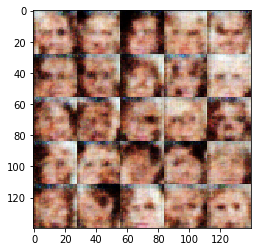

Epoch 1/1... Batch 1810... Discriminator Loss: 0.5459... Generator Loss: 3.0949
Epoch 1/1... Batch 1820... Discriminator Loss: 0.5315... Generator Loss: 2.6970
Epoch 1/1... Batch 1830... Discriminator Loss: 0.5653... Generator Loss: 2.9946
Epoch 1/1... Batch 1840... Discriminator Loss: 0.5258... Generator Loss: 2.9067
Epoch 1/1... Batch 1850... Discriminator Loss: 0.5312... Generator Loss: 2.8619
Epoch 1/1... Batch 1860... Discriminator Loss: 0.5733... Generator Loss: 2.6759
Epoch 1/1... Batch 1870... Discriminator Loss: 0.5042... Generator Loss: 3.2845
Epoch 1/1... Batch 1880... Discriminator Loss: 0.5147... Generator Loss: 4.6884
Epoch 1/1... Batch 1890... Discriminator Loss: 0.6915... Generator Loss: 3.4563
Epoch 1/1... Batch 1900... Discriminator Loss: 0.8334... Generator Loss: 1.6583


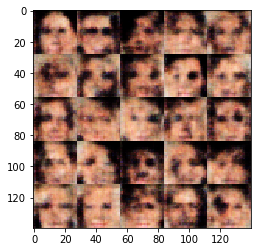

Epoch 1/1... Batch 1910... Discriminator Loss: 0.5687... Generator Loss: 2.6503
Epoch 1/1... Batch 1920... Discriminator Loss: 0.6092... Generator Loss: 3.2229
Epoch 1/1... Batch 1930... Discriminator Loss: 0.6294... Generator Loss: 3.1276
Epoch 1/1... Batch 1940... Discriminator Loss: 0.5376... Generator Loss: 3.2059
Epoch 1/1... Batch 1950... Discriminator Loss: 0.5213... Generator Loss: 3.1228
Epoch 1/1... Batch 1960... Discriminator Loss: 0.5543... Generator Loss: 3.1880
Epoch 1/1... Batch 1970... Discriminator Loss: 0.5842... Generator Loss: 2.7430
Epoch 1/1... Batch 1980... Discriminator Loss: 0.5634... Generator Loss: 2.7196
Epoch 1/1... Batch 1990... Discriminator Loss: 0.7004... Generator Loss: 2.3252
Epoch 1/1... Batch 2000... Discriminator Loss: 0.5132... Generator Loss: 3.2372


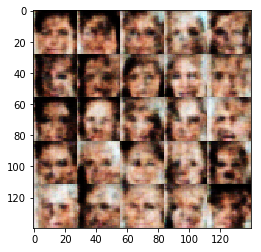

Epoch 1/1... Batch 2010... Discriminator Loss: 0.5247... Generator Loss: 3.6278
Epoch 1/1... Batch 2020... Discriminator Loss: 0.5004... Generator Loss: 3.6416
Epoch 1/1... Batch 2030... Discriminator Loss: 0.6798... Generator Loss: 2.4938
Epoch 1/1... Batch 2040... Discriminator Loss: 0.5638... Generator Loss: 2.7645
Epoch 1/1... Batch 2050... Discriminator Loss: 0.5125... Generator Loss: 3.0480
Epoch 1/1... Batch 2060... Discriminator Loss: 0.5813... Generator Loss: 2.4497
Epoch 1/1... Batch 2070... Discriminator Loss: 0.6087... Generator Loss: 2.4220
Epoch 1/1... Batch 2080... Discriminator Loss: 0.5983... Generator Loss: 2.1184
Epoch 1/1... Batch 2090... Discriminator Loss: 0.6169... Generator Loss: 3.4783
Epoch 1/1... Batch 2100... Discriminator Loss: 0.6010... Generator Loss: 4.0609


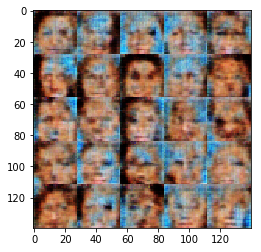

Epoch 1/1... Batch 2110... Discriminator Loss: 0.5457... Generator Loss: 3.6357
Epoch 1/1... Batch 2120... Discriminator Loss: 0.8055... Generator Loss: 3.4899
Epoch 1/1... Batch 2130... Discriminator Loss: 0.6220... Generator Loss: 3.0498
Epoch 1/1... Batch 2140... Discriminator Loss: 0.5704... Generator Loss: 2.7995
Epoch 1/1... Batch 2150... Discriminator Loss: 0.5960... Generator Loss: 3.0090
Epoch 1/1... Batch 2160... Discriminator Loss: 0.7497... Generator Loss: 2.0430
Epoch 1/1... Batch 2170... Discriminator Loss: 0.6067... Generator Loss: 2.6434
Epoch 1/1... Batch 2180... Discriminator Loss: 0.6706... Generator Loss: 3.5873
Epoch 1/1... Batch 2190... Discriminator Loss: 0.5632... Generator Loss: 2.6407
Epoch 1/1... Batch 2200... Discriminator Loss: 0.5281... Generator Loss: 2.7463


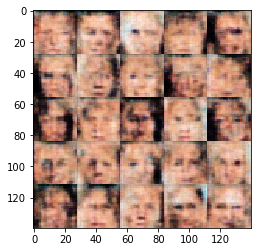

Epoch 1/1... Batch 2210... Discriminator Loss: 0.4876... Generator Loss: 3.4019
Epoch 1/1... Batch 2220... Discriminator Loss: 0.7069... Generator Loss: 2.4961
Epoch 1/1... Batch 2230... Discriminator Loss: 0.5075... Generator Loss: 3.7779
Epoch 1/1... Batch 2240... Discriminator Loss: 0.6146... Generator Loss: 2.4421
Epoch 1/1... Batch 2250... Discriminator Loss: 0.6896... Generator Loss: 2.3136
Epoch 1/1... Batch 2260... Discriminator Loss: 0.7890... Generator Loss: 2.6158
Epoch 1/1... Batch 2270... Discriminator Loss: 0.6941... Generator Loss: 1.8028
Epoch 1/1... Batch 2280... Discriminator Loss: 0.6195... Generator Loss: 2.5510
Epoch 1/1... Batch 2290... Discriminator Loss: 0.6798... Generator Loss: 3.1825
Epoch 1/1... Batch 2300... Discriminator Loss: 0.4908... Generator Loss: 3.7610


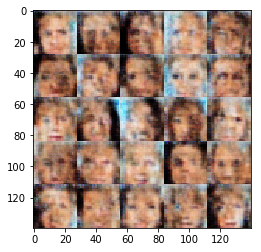

Epoch 1/1... Batch 2310... Discriminator Loss: 0.6992... Generator Loss: 2.8310
Epoch 1/1... Batch 2320... Discriminator Loss: 0.5497... Generator Loss: 2.1736
Epoch 1/1... Batch 2330... Discriminator Loss: 0.6204... Generator Loss: 3.1745
Epoch 1/1... Batch 2340... Discriminator Loss: 0.5670... Generator Loss: 2.4669
Epoch 1/1... Batch 2350... Discriminator Loss: 0.7434... Generator Loss: 2.3982
Epoch 1/1... Batch 2360... Discriminator Loss: 0.4580... Generator Loss: 3.7212
Epoch 1/1... Batch 2370... Discriminator Loss: 0.5701... Generator Loss: 2.5681
Epoch 1/1... Batch 2380... Discriminator Loss: 0.5501... Generator Loss: 2.7180
Epoch 1/1... Batch 2390... Discriminator Loss: 0.5731... Generator Loss: 2.4919
Epoch 1/1... Batch 2400... Discriminator Loss: 0.6567... Generator Loss: 2.6204


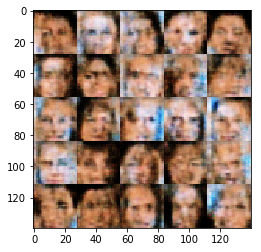

Epoch 1/1... Batch 2410... Discriminator Loss: 0.5494... Generator Loss: 2.3509
Epoch 1/1... Batch 2420... Discriminator Loss: 0.6368... Generator Loss: 2.4680
Epoch 1/1... Batch 2430... Discriminator Loss: 0.5748... Generator Loss: 2.9277
Epoch 1/1... Batch 2440... Discriminator Loss: 0.6660... Generator Loss: 2.8345
Epoch 1/1... Batch 2450... Discriminator Loss: 0.6832... Generator Loss: 2.2641
Epoch 1/1... Batch 2460... Discriminator Loss: 0.6883... Generator Loss: 2.4194
Epoch 1/1... Batch 2470... Discriminator Loss: 0.6764... Generator Loss: 3.0659
Epoch 1/1... Batch 2480... Discriminator Loss: 0.6678... Generator Loss: 2.1651
Epoch 1/1... Batch 2490... Discriminator Loss: 0.7554... Generator Loss: 1.7821
Epoch 1/1... Batch 2500... Discriminator Loss: 0.6007... Generator Loss: 3.0900


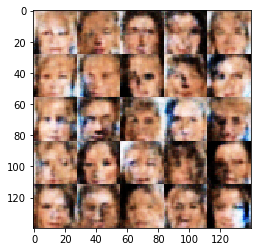

Epoch 1/1... Batch 2510... Discriminator Loss: 0.6637... Generator Loss: 2.6961
Epoch 1/1... Batch 2520... Discriminator Loss: 0.8216... Generator Loss: 2.2413
Epoch 1/1... Batch 2530... Discriminator Loss: 0.6726... Generator Loss: 2.3181
Epoch 1/1... Batch 2540... Discriminator Loss: 0.5388... Generator Loss: 3.8205
Epoch 1/1... Batch 2550... Discriminator Loss: 0.7187... Generator Loss: 2.7963
Epoch 1/1... Batch 2560... Discriminator Loss: 0.9029... Generator Loss: 1.4053
Epoch 1/1... Batch 2570... Discriminator Loss: 0.8035... Generator Loss: 2.9242
Epoch 1/1... Batch 2580... Discriminator Loss: 0.6674... Generator Loss: 2.1755
Epoch 1/1... Batch 2590... Discriminator Loss: 0.8635... Generator Loss: 1.5519
Epoch 1/1... Batch 2600... Discriminator Loss: 0.6827... Generator Loss: 2.2069


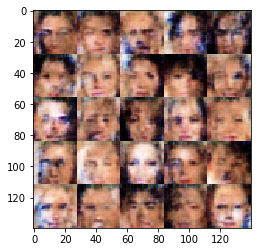

Epoch 1/1... Batch 2610... Discriminator Loss: 0.7144... Generator Loss: 3.4451
Epoch 1/1... Batch 2620... Discriminator Loss: 0.6536... Generator Loss: 2.3978
Epoch 1/1... Batch 2630... Discriminator Loss: 0.6579... Generator Loss: 2.6377
Epoch 1/1... Batch 2640... Discriminator Loss: 0.7176... Generator Loss: 2.2336
Epoch 1/1... Batch 2650... Discriminator Loss: 0.7258... Generator Loss: 2.3686
Epoch 1/1... Batch 2660... Discriminator Loss: 0.6269... Generator Loss: 2.8755
Epoch 1/1... Batch 2670... Discriminator Loss: 0.5870... Generator Loss: 2.9793
Epoch 1/1... Batch 2680... Discriminator Loss: 0.6498... Generator Loss: 2.7422
Epoch 1/1... Batch 2690... Discriminator Loss: 0.6118... Generator Loss: 2.6643
Epoch 1/1... Batch 2700... Discriminator Loss: 0.6922... Generator Loss: 2.2762


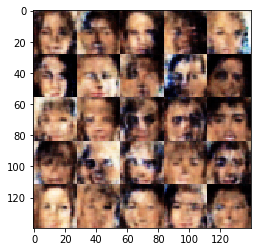

Epoch 1/1... Batch 2710... Discriminator Loss: 0.7059... Generator Loss: 2.5106
Epoch 1/1... Batch 2720... Discriminator Loss: 0.6815... Generator Loss: 2.2157
Epoch 1/1... Batch 2730... Discriminator Loss: 0.6370... Generator Loss: 2.7426
Epoch 1/1... Batch 2740... Discriminator Loss: 0.6459... Generator Loss: 2.3258
Epoch 1/1... Batch 2750... Discriminator Loss: 0.6995... Generator Loss: 2.4677
Epoch 1/1... Batch 2760... Discriminator Loss: 0.8134... Generator Loss: 1.8951
Epoch 1/1... Batch 2770... Discriminator Loss: 0.7903... Generator Loss: 2.6058
Epoch 1/1... Batch 2780... Discriminator Loss: 0.5910... Generator Loss: 3.0529
Epoch 1/1... Batch 2790... Discriminator Loss: 0.6737... Generator Loss: 3.0037
Epoch 1/1... Batch 2800... Discriminator Loss: 0.7337... Generator Loss: 2.3353


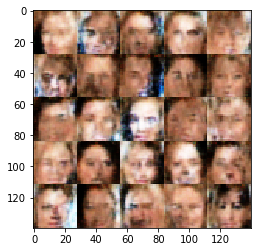

Epoch 1/1... Batch 2810... Discriminator Loss: 0.6164... Generator Loss: 2.8746
Epoch 1/1... Batch 2820... Discriminator Loss: 0.8163... Generator Loss: 1.8922
Epoch 1/1... Batch 2830... Discriminator Loss: 0.8019... Generator Loss: 2.1160
Epoch 1/1... Batch 2840... Discriminator Loss: 0.7460... Generator Loss: 2.3295
Epoch 1/1... Batch 2850... Discriminator Loss: 0.8581... Generator Loss: 1.9030
Epoch 1/1... Batch 2860... Discriminator Loss: 0.7765... Generator Loss: 2.2271
Epoch 1/1... Batch 2870... Discriminator Loss: 0.8759... Generator Loss: 2.1196
Epoch 1/1... Batch 2880... Discriminator Loss: 0.7027... Generator Loss: 2.5760
Epoch 1/1... Batch 2890... Discriminator Loss: 0.6534... Generator Loss: 2.8658
Epoch 1/1... Batch 2900... Discriminator Loss: 0.6924... Generator Loss: 2.3337


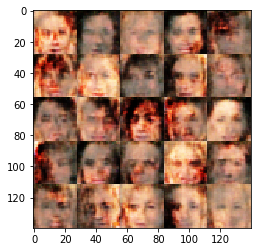

Epoch 1/1... Batch 2910... Discriminator Loss: 0.6578... Generator Loss: 3.0001
Epoch 1/1... Batch 2920... Discriminator Loss: 0.6549... Generator Loss: 3.1559
Epoch 1/1... Batch 2930... Discriminator Loss: 0.7980... Generator Loss: 3.1498
Epoch 1/1... Batch 2940... Discriminator Loss: 0.9103... Generator Loss: 2.1609
Epoch 1/1... Batch 2950... Discriminator Loss: 0.7145... Generator Loss: 2.8830
Epoch 1/1... Batch 2960... Discriminator Loss: 0.8051... Generator Loss: 2.2019
Epoch 1/1... Batch 2970... Discriminator Loss: 0.8550... Generator Loss: 1.9432
Epoch 1/1... Batch 2980... Discriminator Loss: 0.7715... Generator Loss: 2.2050
Epoch 1/1... Batch 2990... Discriminator Loss: 0.7456... Generator Loss: 2.2631
Epoch 1/1... Batch 3000... Discriminator Loss: 0.9448... Generator Loss: 1.9258


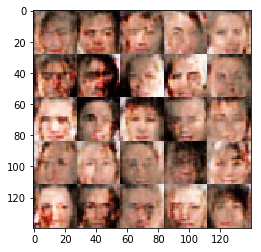

Epoch 1/1... Batch 3010... Discriminator Loss: 0.6058... Generator Loss: 2.8019
Epoch 1/1... Batch 3020... Discriminator Loss: 0.8228... Generator Loss: 2.1941
Epoch 1/1... Batch 3030... Discriminator Loss: 0.8504... Generator Loss: 1.8504
Epoch 1/1... Batch 3040... Discriminator Loss: 0.7821... Generator Loss: 2.2236
Epoch 1/1... Batch 3050... Discriminator Loss: 0.8581... Generator Loss: 2.4395
Epoch 1/1... Batch 3060... Discriminator Loss: 0.6851... Generator Loss: 2.3821
Epoch 1/1... Batch 3070... Discriminator Loss: 0.6796... Generator Loss: 2.3813
Epoch 1/1... Batch 3080... Discriminator Loss: 0.8666... Generator Loss: 1.8135
Epoch 1/1... Batch 3090... Discriminator Loss: 0.6624... Generator Loss: 2.2994
Epoch 1/1... Batch 3100... Discriminator Loss: 0.8075... Generator Loss: 1.8777


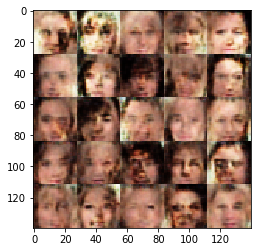

Epoch 1/1... Batch 3110... Discriminator Loss: 0.6956... Generator Loss: 2.5127
Epoch 1/1... Batch 3120... Discriminator Loss: 0.7711... Generator Loss: 1.6280
Epoch 1/1... Batch 3130... Discriminator Loss: 0.6197... Generator Loss: 2.5611
Epoch 1/1... Batch 3140... Discriminator Loss: 0.5954... Generator Loss: 3.6488
Epoch 1/1... Batch 3150... Discriminator Loss: 0.5452... Generator Loss: 3.0365
Epoch 1/1... Batch 3160... Discriminator Loss: 0.6865... Generator Loss: 1.9292


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.